# **Fast Food Marketing Campaign A/B Test Analysis - Analysis Notebook File**

In [5]:
from IPython.display import HTML
display(HTML('<img src="Marketing_Campaign_AB_Test.png" width="1200">'))

## **Introduction**
### 1. Goal of the A/B Test 🎯
A fast-food chain is planning to add a new item to its menu but is undecided between three possible marketing campaigns for promoting this product. To determine which promotion has the greatest effect on sales, the new item was introduced at locations in several randomly selected markets.

This multivariate test compares three different promotion strategies:
- **Promotion 1**: First promotional strategy (baseline)
- **Promotion 2**: Second promotional strategy  
- **Promotion 3**: Third promotional strategy

The primary goal is to identify which marketing strategy most effectively drives sales of the new menu item to inform the nationwide rollout strategy.

### 2. Target Metric 📊
The primary target metric will be **average sales in thousands** (`SalesInThousands`) for each promotion. This metric directly measures the effectiveness of each marketing campaign in driving sales of the new menu item, which aligns with the business goal.

This metric is particularly valuable because:
1. It directly impacts revenue and profitability
2. It provides clear indication of customer interest and adoption
3. It allows for straightforward comparison between promotional strategies
4. It can be tracked consistently across different market sizes and store ages

Additional metrics we'll analyze include:
- **Weekly growth rate** to assess momentum and adoption trends
- **Sales consistency** (coefficient of variation) to evaluate reliability
- **Performance by store characteristics** to identify potential segment-specific effects

By analyzing these metrics over the four-week test period, we can determine not only which promotion performs best overall, but also whether performance is consistent over time and across different store types.


### 3. Hypothesis Testing Framework 🧪
To rigorously evaluate promotional effectiveness, we formulate the following hypotheses:

**Null Hypothesis (H₀)**: There is no significant difference in sales performance among the three promotional strategies (μ₁ = μ₂ = μ₃).

**Alternative Hypothesis (H₁)**: At least one promotion produces significantly different sales performance compared to the others (at least one μᵢ ≠ μⱼ).

Where μ₁, μ₂, and μ₃ represent the mean sales generated by Promotions 1, 2, and 3, respectively.

The hypothesis testing will be conducted using one-way ANOVA and pairwise t-tests with a significance level of α = 0.05.

## **1. Data loading and initial insepction**

#### **<ins>1.1 Import necessary modules to load, read the data and create the data frame for analysis:</ins>**

This also includes the `marketing_campaign_functions.py` file which is a separate Python file containing all the visualization functions.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
import warnings
import marketing_campaign_functions as viz

In [7]:
plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('WA_Marketing-Campaign.csv')

#### **<ins>1.2 Display the first few rows and inspect the shape of the data frame to get an idea of the data:</ins>**

In [9]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [10]:
print(f"Dataset shape: {df.shape}")
df.info()

Dataset shape: (548, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


Pandas will not raise an error when encountering a column with mixed types like this. Instead, it will infer the dtype based on what it can handle. Therefore it is important to verify if each row in a column has the same data type, i.e. the dataset may have errors where accidentally categorical values appear in numerical columns and vice versa. This is just to check that every column also has the same data type for all values:

In [11]:
def check_column_types(df):

    """
    Checks whether each column has consistent data types within each column in case a different data type was pasted in a column where it shouldn't be.
    
    """
    inconsistent_columns = {}

    for column in df.columns:
        if df[column].dtype == 'O': 
            unique_types = df[column].map(type).unique()
            if len(unique_types) > 1:
                inconsistent_columns[column] = unique_types

    return inconsistent_columns

inconsistent_columns = check_column_types(df)

if inconsistent_columns:
    print("Columns with inconsistent data types:")
    for column, types in inconsistent_columns.items():
        print(f"Column: {column} has mixed types: {types}")
else:
    print("\nAll columns have consistent data types!")


All columns have consistent data types!


#### **<ins>1.3 Check for missing values:</ins>**

Missing values can appear in various forms in a dataset, such as:

* NaN (Not a Number)
* Empty cells in the CSV (could be treated as empty strings "" or NaN)
* Missing data can also be reflected as placeholder stings ('/', '-', '--') which need to be accounted for
* Zeros (although this depends on the context - sometimes 0 might be a valid value, other times it’s a placeholder for missing data)

In [12]:
missing_placeholders = ['/', '-', '--']

missing_values = df.isnull()

missing_count = missing_values.sum()

empty_string_count = (df == "").sum()

placeholder_count = df.isin(missing_placeholders).sum()
 
display(pd.DataFrame({'Missing values count': missing_count, 
                      'Empty string count': empty_string_count, 
                      'Placeholder count': placeholder_count}))

if missing_count.sum() == 0 and empty_string_count.sum() == 0 and placeholder_count.sum() == 0:
    print("\nNo missing values, empty strings or placeholders found in any column.")
else:
    print("\nColumns with missing values, empty strings or placeholders: ")
    
    missing_or_placeholder = missing_values | (df == "") | df.isin(missing_placeholders)
    display(missing_or_placeholder[missing_or_placeholder.any()])  

    display(missing_count[missing_count > 0]) 
    display(empty_string_count[empty_string_count > 0])  
    display(placeholder_count[placeholder_count > 0])

,Missing values count,Empty string count,Placeholder count
MarketID,0,0,0
MarketSize,0,0,0
LocationID,0,0,0
AgeOfStore,0,0,0
Promotion,0,0,0
week,0,0,0
SalesInThousands,0,0,0



No missing values, empty strings or placeholders found in any column.


#### **<ins>1.4 Check for zero values:</ins>**

Checking for zeros separetly - sometimes the value '0' may be a valid value, whereas in other caes it can be a missing value. Looking at all columns and identifying certain features where '0' appears:

In [13]:
zero_count = (df.select_dtypes(include='number') == 0).sum()

if zero_count.sum() == 0:
    display("No zeros found in any numeric columns.")
else:
    display(zero_count_df[zero_count > 0])

'No zeros found in any numeric columns.'

#### **<ins>1.5 Check for duplicates:</ins>**

In [14]:
duplicates = df.duplicated()

if duplicates.any(): 
    print("Duplicates found:")
    display(df_cleaned[duplicates])
else:
    print("No duplicates found in the dataset.")

No duplicates found in the dataset.


### **2. Data Exploration, Cleaning and Preparation**

#### **<ins>2.1 Univariant Analysis:</ins>**

**2.1.1 Distribution of Sales:**

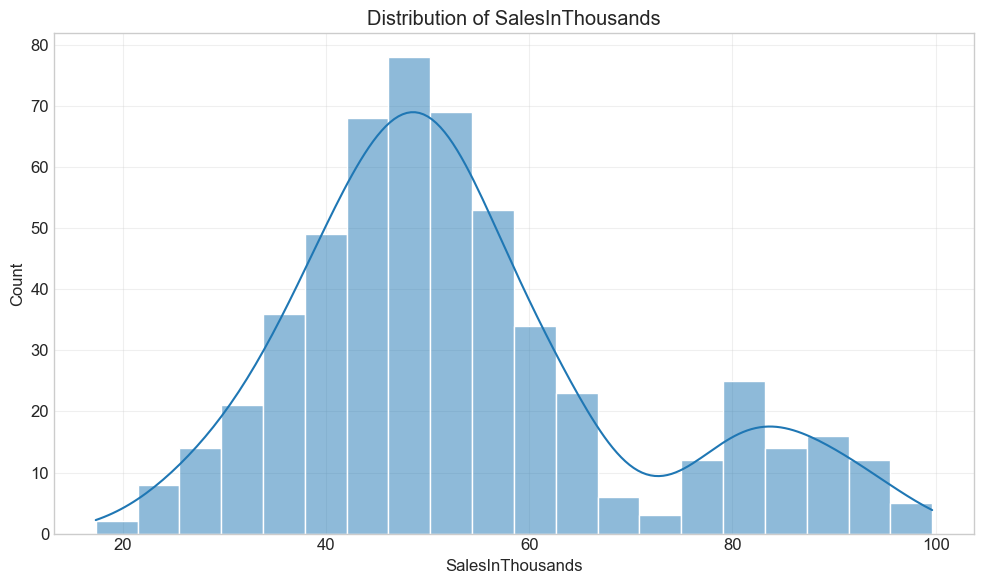

In [28]:
import marketing_campaign_functions as viz
import importlib
importlib.reload(viz)
viz.plot_univariate_numerical(df, 'SalesInThousands')

**Observation:**

* **Bimodal Distribution:** The sales data shows a clear bimodal distribution with two distinct peaks - a larger one around 45-50 thousand and a smaller one around 80 thousand.
* **Primary Sales Range:** The majority of store locations have sales between 30-60 thousand, forming the main cluster in the distribution.
* **High-Performance Segment:** There appears to be a distinct segment of high-performing locations with sales between 75-90 thousand, creating the second peak.
* **Overall Range:** Sales values span from approximately 20 thousand to 100 thousand, with most concentrated in the 35-65 thousand range.
* **Potential Outliers:** The secondary peak could indicate either outlier high-performing stores or potentially a separate market segment (possibly related to market size).


**2.1.1 Distribution of Store Age:**

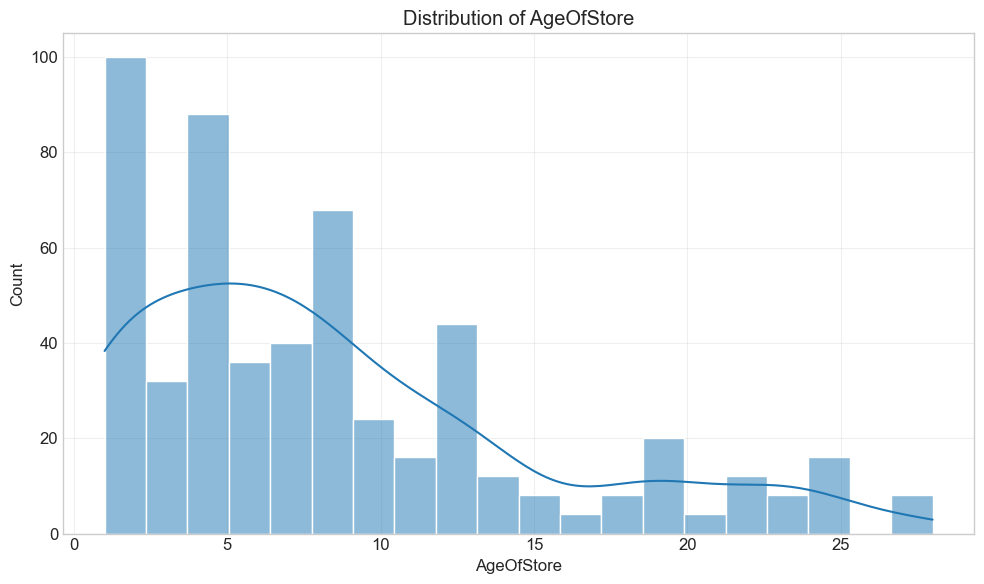

In [29]:
import marketing_campaign_functions as viz
import importlib
importlib.reload(viz)
viz.plot_univariate_numerical(df, 'AgeOfStore')

**Observation:**

* **Right-Skewed Distribution:** The store age distribution is heavily right-skewed, with most stores being relatively young (0-10 years old).
* **Newest Stores Predominant:** There's a particularly high concentration of very new stores (0-2 years), which form the highest bar in the histogram.
* **Secondary Peak:** There's a notable peak at around 5 years, indicating a possible expansion period for the chain at that time.
* **Long Tail:** A small number of stores are much older (15-25+ years), forming a long tail in the distribution.
* **Age Clustering:** There appear to be several discrete clusters (0-2, 5, 8, 12 years), which might represent specific expansion periods for the company.

#### **<ins>2.2 Bivariant Analysis:</ins>**

**2.2.1 Sales by Promotion:**

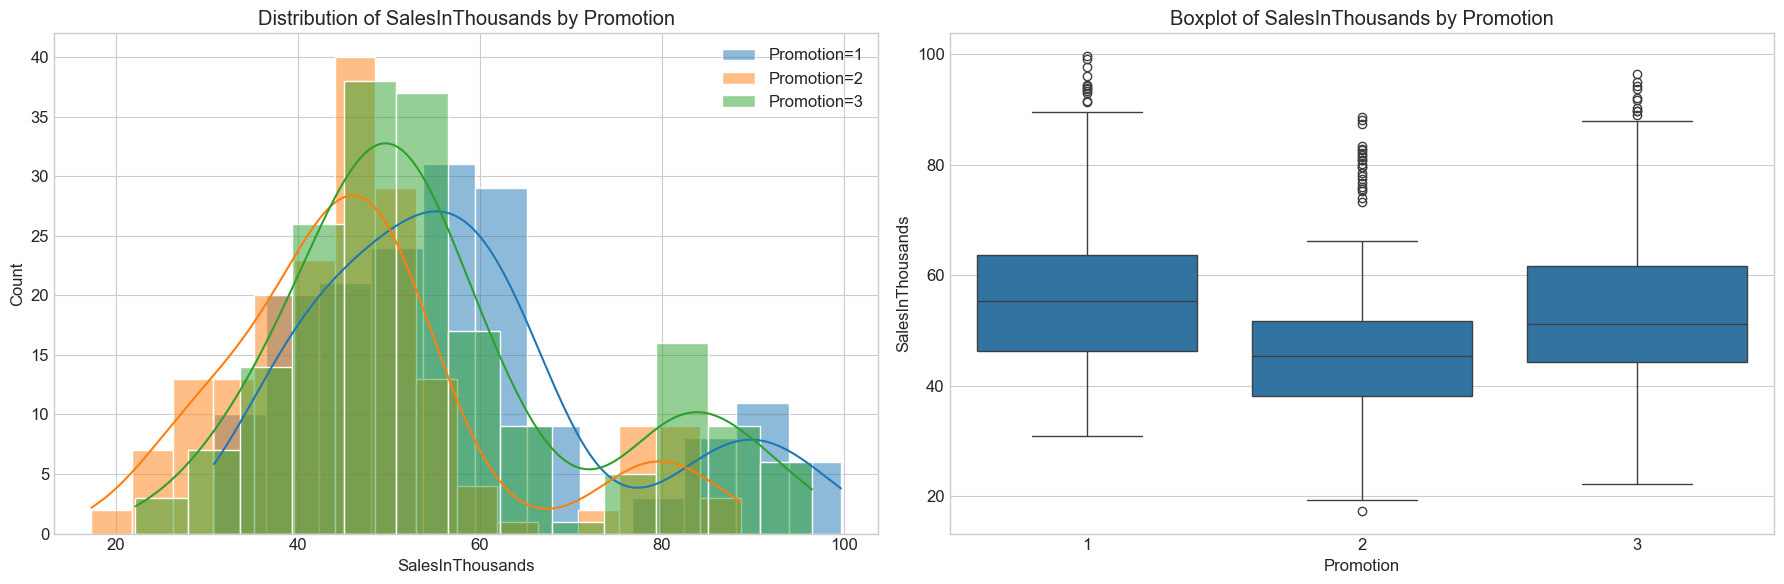

In [23]:
import marketing_campaign_functions as viz
import importlib
importlib.reload(viz)
viz.plot_distributions(df, 'SalesInThousands', 'Promotion')

**Observation:**

* **Distribution Differences:** The histograms show distinct distribution patterns across the three promotions. Promotion 1 and 3 have similar, slightly right-skewed distributions, while Promotion 2 shows a more centralized, lower distribution.
* **Median Performance:** The boxplots clearly show that Promotion 2 has the lowest median sales (approximately 47 thousand), while Promotion 1 and 3 have higher medians (approximately 58 and 55 thousand respectively).
* **Bimodal Pattern:** Promotions 1 and 3 show signs of bimodality with peaks around 45-50 thousand and another around 80 thousand, suggesting two different performance tiers across stores.
* **Consistency:** Promotion 2 shows less spread than the others, but this is primarily because its overall performance is consistently lower rather than due to better consistency at higher sales levels.
* **Outliers:** All three promotions have some high-performing outlier stores (dots above the whiskers), indicating exceptional performance in some locations regardless of promotion type.

**2.2.2 Sales by Market Size:**

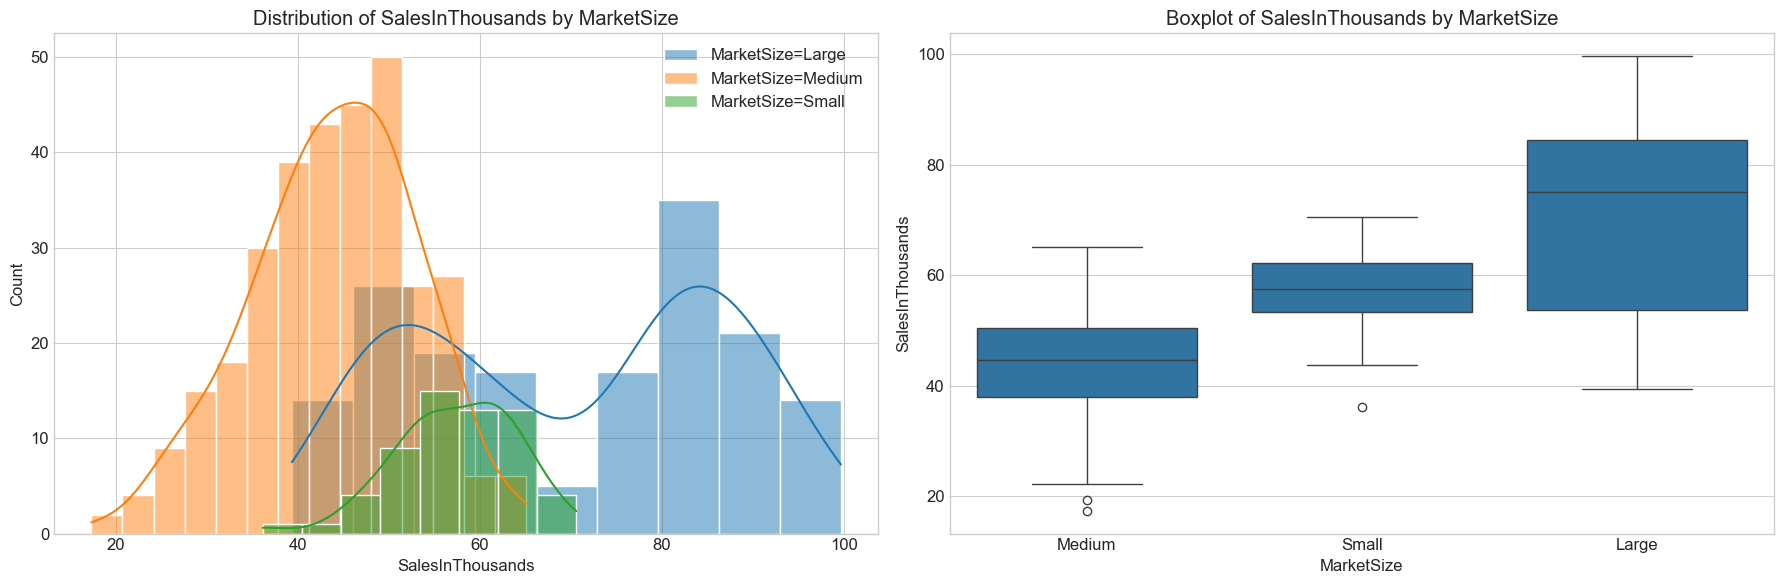

In [31]:
import marketing_campaign_functions as viz
import importlib
importlib.reload(viz)
viz.plot_distributions(df, 'SalesInThousands', 'MarketSize')

**Observation:**

* **Clear Size Effect:** There's a strong relationship between market size and sales, with Large markets showing dramatically higher sales than Medium and Small markets.
* **Distribution Separation:** Large markets have a distinctly bimodal distribution with a significant peak around 80-85 thousand, clearly separated from Medium and Small markets.
* **Medium vs. Small Difference:** Medium markets show lower sales (centered around 40-45 thousand) compared to Small markets (centered around 55-60 thousand), which is somewhat counterintuitive.
* **Variance by Size:** Large markets show the widest spread in sales performance, suggesting greater variability in larger markets.
* **Outlier Pattern:** Medium markets have several low outliers, while the other market sizes have fewer outliers, suggesting more consistent baseline performance in Small and Large markets.

**2.2.3 Sales by Week:**

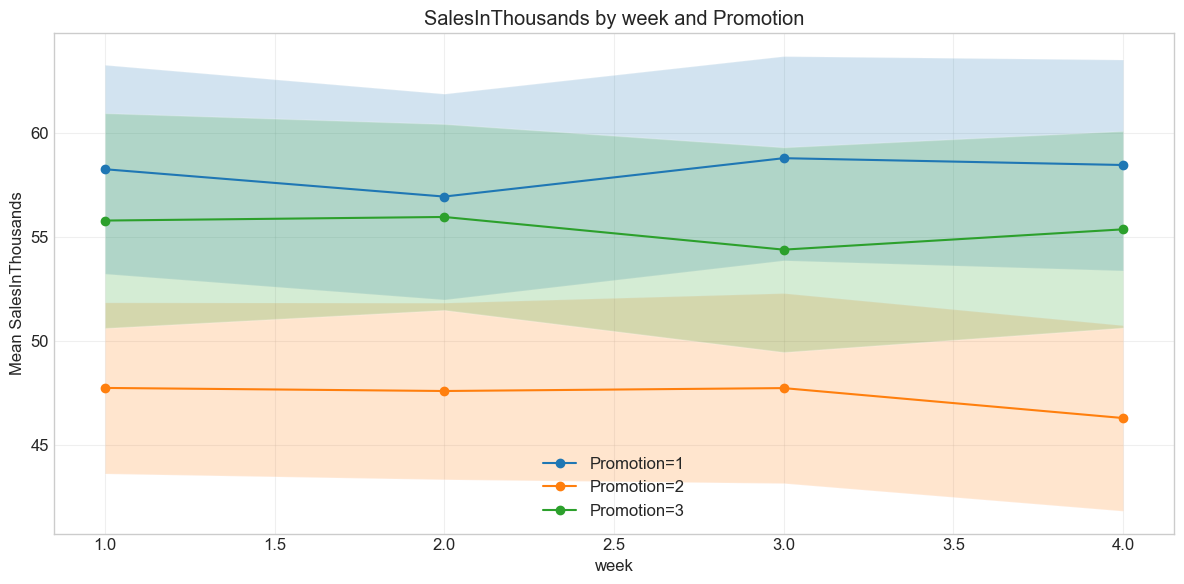

In [32]:
import marketing_campaign_functions as viz
import importlib
importlib.reload(viz)
viz.plot_target_by_week(df, 'SalesInThousands', 'Promotion')

**Observation:**

**Colored Lines:** Each colored line represents the mean (average) sales for a specific promotion across the four weeks:

* Blue line (Promotion 1): Shows the highest overall performance, ranging between approximately 57-58 thousand
* Green line (Promotion 3): Shows the middle performance, ranging between approximately 54-56 thousand
* Orange line (Promotion 2): Shows consistently lower performance around 46-47 thousand

**Shaded Areas:** The colored shaded regions around each line represent the 95% confidence intervals for the mean sales:

* These indicate the range within which we can be 95% confident the true mean sales value lies
* Wider shaded areas indicate more variability/uncertainty in the estimate
* Where confidence intervals overlap between promotions (like between Promotion 1 and 3), we cannot be statistically confident that there's a real difference

**Temporal Patterns:**

* Promotion 1 shows a dip in week 2, followed by a peak in week 3, then slight decrease in week 4
* Promotion 3 remains relatively stable in weeks 1-2, decreases in week 3, then increases slightly in week 4
* Promotion 2 remains stable across weeks 1-3, then drops noticeably in week 4

**Consistency of Effects:**

* The clear separation between Promotion 2 and the others persists throughout all four weeks
* Promotion 1 and 3 have overlapping confidence intervals throughout, confirming the lack of statistically significant difference between them
* The relative ranking of promotions remains stable across the entire test period (Promotion 1 > Promotion 3 > Promotion 2)

**2.2.4 Advanced Exploratory Analysis:**

* Weekly growth rate analysis
* Sales consistency

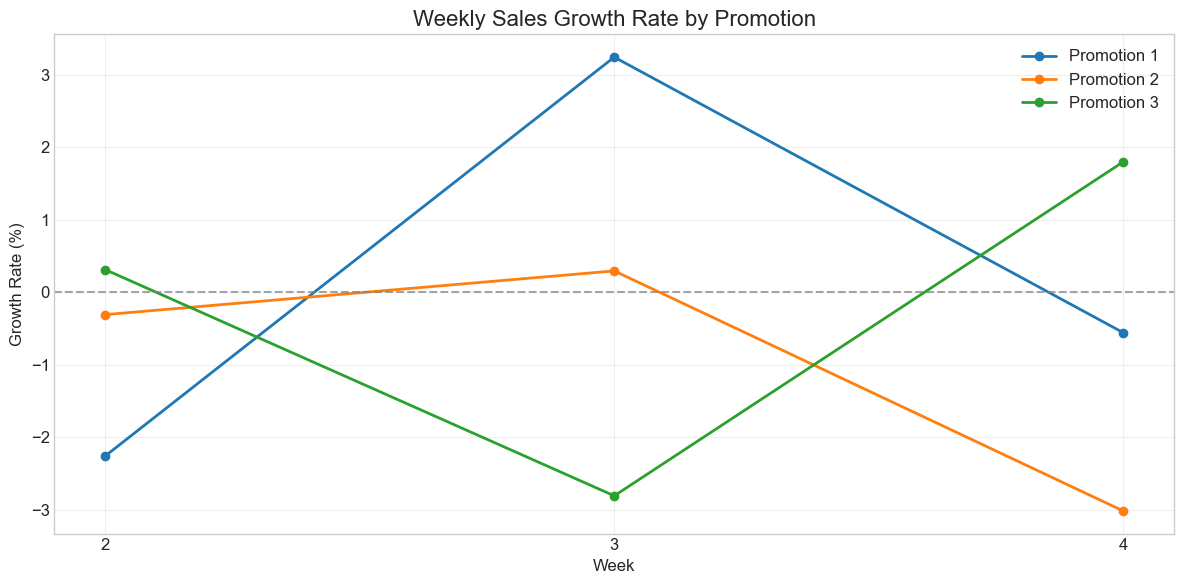

Average weekly growth rate by Promotion:


,Promotion,Growth_Rate
0,1,0.142142
1,2,-1.010721
2,3,-0.233979


In [40]:
import marketing_campaign_functions as viz
import importlib
importlib.reload(viz)
growth_df, avg_growth = viz.analyze_weekly_growth(df)

<ins>The weekly growth rates were calculated by:</ins>

* First grouping the data by week and promotion to get average sales for each week-promotion combination
* For each promotion, calculating the percentage change from one week to the next:
* Growth Rate = ((Current Week Sales - Previous Week Sales) / Previous Week Sales) × 100%
* Averaging these weekly percentage changes for each promotion to get the overall average growth rate

**Observation:**

**Promotion 1 (Blue):**

* Shows high volatility in growth rates
* Starts with a negative growth rate in week 2 (-2.2%)
* Experiences a strong surge in week 3 (approximately 3.2%)
* Declines to a negative rate again in week 4 (-0.6%)
* Despite this volatility, its average growth rate remains slightly positive overall (0.14%)

**Promotion 2 (Orange):**

* Shows initial stability with slight improvement in weeks 2-3
* Experiences a severe decline in week 4 (approximately -3%)
* Demonstrates a consistent downward trend in the second half of the testing period
* This final steep decline drives its overall negative average growth rate (-1.01%)

**Promotion 3 (Green):**

* Begins with a positive growth rate in week 2 (0.3%)
* Experiences a significant drop in week 3 (approximately -2.8%)
* Rebounds strongly in week 4 with the highest final week growth rate (1.8%)
* Shows the most dramatic recovery pattern among all promotions

**Implications:**

* The high volatility in growth rates across all promotions suggests that sales momentum may be influenced by factors beyond just the promotion type, such as day-of-week effects or external market factors.
* Promotion 2's consistent decline in the latter half reinforces earlier findings that it's the least effective option.
* Promotion 3's strong recovery in the final week is noteworthy and suggests it might have good long-term potential despite its slightly negative average growth rate.
* Promotion 1's pattern suggests it can generate short bursts of high growth, but may not sustain them consistently.

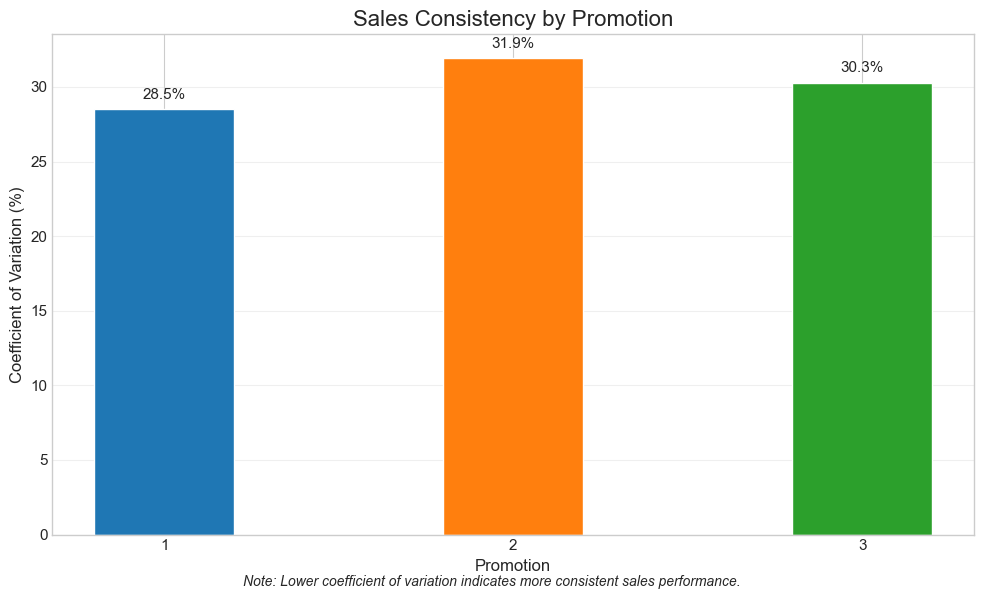

Sales consistency analysis (coefficient of variation):
Promotion 1: 28.5%
Promotion 2: 31.9%
Promotion 3: 30.3%

Lower values indicate more consistent (less variable) sales across locations.


In [41]:
import marketing_campaign_functions as viz
import importlib
importlib.reload(viz)
consistency_data = viz.analyze_sales_consistency(df)

**The coefficient of variation (CV)** is a standardized measure of dispersion that allows to compare the variability of different datasets with different means. In the context of this analysis, a promotion with a lower CV indicates that it produces more consistent sales results across different locations, which is generally preferable for business planning and risk management.

* It's calculated as: CV = (Standard Deviation / Mean) × 100%
* Lower values indicate more consistent (less variable) sales performance
* Higher values indicate more unpredictable or variable sales performance

**Key Findings from the Plot:**

* **Promotion 1 (Blue):** Has the lowest coefficient of variation at 28.5%, indicating it produces the most consistent sales results across different store locations. This suggests more reliable and predictable performance.
* **Promotion 2 (Orange):** Shows the highest variability with a CV of 31.9%, making it the least consistent option. Despite having lower overall sales, its performance is also the most unpredictable from location to location.
* **Promotion 3 (Green):** Has a moderate CV of 30.3%, placing it between the other two promotions in terms of consistency.

**Business Implications:**

* **Forecasting Accuracy:** Promotion 1's lower variability makes sales forecasting more reliable, which is valuable for inventory planning and resource allocation.
* **Risk Management:** Higher variability (as seen in Promotion 2) represents greater risk, as some locations might significantly underperform expectations.
* **Market Adaptability:** The difference between Promotions 1 and 3 in terms of consistency (approximately 1.8 percentage points) is meaningful but not dramatic, suggesting both could be viable options depending on other factors.

#### **<ins>2.3 Data Quality Checks and Preparation:</ins>**

**2.3.1 Outlier Analysis:**

In [26]:
outliers = viz.analyze_outliers(df, 'SalesInThousands')
if len(outliers) > 0:
    display(outliers[['MarketID', 'LocationID', 'Promotion', 'SalesInThousands']].head(10))

Outlier analysis for SalesInThousands:
  Q1: 42.55, Q3: 60.48, IQR: 17.93
  Lower bound: 15.65, Upper bound: 87.38
  Found 33 outliers (6.02% of data)


,MarketID,LocationID,Promotion,SalesInThousands
80,3,202,1,88.73
83,3,202,1,94.17
84,3,203,3,89.70
88,3,204,2,87.43
90,3,204,2,88.12
93,3,205,3,90.30
95,3,205,3,89.77
99,3,206,3,88.91
100,3,207,3,87.70
103,3,207,3,94.21


**Percentage of Outliers:** The dataset contains 33 outliers, representing 6.02% of the total data. This is a relatively small proportion that doesn't warrant wholesale removal.

**Outlier Characteristics:** All identified outliers are high performers (above the upper bound of 87.38), with no low outliers below the lower bound (15.65). This indicates exceptionally successful sales instances rather than problematic data points.

**Market Pattern:** All outliers shown in the sample come from Market ID 3, suggesting this particular market may have unique characteristics driving higher sales.

**Promotion Distribution:** The outliers span across all three promotion types (Promotion 1, 2, and 3), though Promotion 3 appears more frequently in this sample of outliers.

**Analysis Decision:** These outliers were correctly kept in the dataset because:

* They represent actual business outcomes rather than measurement errors
* Their proportion is relatively small (6.02%)
* Removing them would eliminate valuable information about high-performing scenarios
* They provide insights into potential maximum sales achievable under optimal conditions


**Statistical Approach:** Using non-parametric methods (like Mann-Whitney U) and bootstrap confidence intervals provides robustness against the influence of these outliers without requiring their removal.

**2.3.2 Zero Value Analysis:**

In [33]:
numeric_cols = ['MarketID', 'LocationID', 'AgeOfStore', 'Promotion', 'week', 'SalesInThousands']
zeros_summary = viz.summarize_zeros(df, numeric_cols)
display(zeros_summary)

,Column,Zero Count,Zero Percentage
0,MarketID,0,0.0
1,LocationID,0,0.0
2,AgeOfStore,0,0.0
3,Promotion,0,0.0
4,week,0,0.0
5,SalesInThousands,0,0.0


**2.3.3 Sample Ratio Mismatch:**

In [75]:
location_counts = df.groupby(['LocationID', 'Promotion']).size().reset_index(name='count')
promotion_location_counts = location_counts.groupby('Promotion').size()
print("Number of unique locations per promotion:")
print(promotion_location_counts)

viz.check_sample_ratio_mismatch(location_counts, 'Promotion')

Number of unique locations per promotion:
Promotion
1    43
2    47
3    47
dtype: int64
Sample sizes per group:
Promotion
3    47
2    47
1    43
Name: count, dtype: int64

Chi-square test for sample ratio mismatch:
Chi-square statistic: 0.2336
p-value: 0.8898
No significant sample ratio mismatch detected


(np.float64(0.23357664233576642), np.float64(0.8897735194498095))

* The test locations were distributed across promotions as follows:

    * Promotion 1: 43 locations
    * Promotion 2: 47 locations
    * Promotion 3: 47 locations
      

* **Statistical Test:** The chi-square test produced a statistic of 0.2336 with a p-value of 0.8898, which is well above the conventional significance threshold of 0.05.
* **Interpretation:** The high p-value indicates that the observed differences in sample sizes across promotion groups are well within the range of expected random variation.
* **Randomization Quality:** This confirms that the randomization process used to assign promotions to different locations worked properly, with no significant bias in how locations were allocated.

**Analysis Implications:**

* Any observed differences in performance between promotions are due to the promotions themselves, not sampling bias
* The statistical tests conducted later in the analysis have a sound foundation
* There is no need to apply any correction factors to account for unequal sample sizes


**Validation of Design:** This result validates the experimental design and strengthens the credibility of all subsequent findings.

### **3. Statistical Testing and Confidence Intervals of A/B test Results**

#### **<ins>3.1 Statistical Testing:</ins>**

**3.1.1 Differences among the three promotions: One-way ANOVA Test**

In [76]:
import marketing_campaign_functions as viz
import importlib
importlib.reload(viz)
print("\nOne-way ANOVA test:")
f_stat, p_value = viz.run_anova(df, 'SalesInThousands', 'Promotion')


One-way ANOVA test:
One-way ANOVA results:
  F-statistic: 21.9535
  p-value: 0.0000
  Significant difference detected among groups (p < 0.05)


The one-way ANOVA test examines whether there are any significant differences in sales among the three promotions:

* **F-statistic:** 21.9535 - This large F-value indicates substantial variation between promotion groups relative to variation within groups
* **p-value:** 0.0000 - The extremely small p-value (effectively zero) provides overwhelming evidence to reject the null hypothesis
* **Interpretation:** There is a statistically significant difference in sales performance among at least some of the three promotions
* **Significance:** This initial test confirms that the choice of promotion does matter for sales performance, but doesn't tell us which specific promotions differ from each other



**F-statistic Explanation:**

The F-statistic is a key component of the ANOVA (Analysis of Variance) test:

* **Definition:** The F-statistic measures the ratio of variation between groups to variation within groups
* **Calculation:** F = (Between-group variability) / (Within-group variability)

* **Interpretation:**

* A larger F-value indicates greater differences between groups relative to the variability within groups
* F = 1 would suggest no difference between groups
* F = 21.95 indicates substantial differences between promotion groups


**3.1.2 Identify which promotions differ from each other: Pairwise T-Test**

In [52]:
import marketing_campaign_functions as viz
import importlib
importlib.reload(viz)
print("\nPairwise t-tests between promotions:")
pairwise_results = viz.get_pairwise_t_tests(df, 'SalesInThousands', 'Promotion')
display(pairwise_results)


Pairwise t-tests between promotions:


,Group 1,Group 2,Mean 1,Mean 2,Mean Difference,t-statistic,p-value,Cohen's d,Significant
0,1,2,58.099012,47.329415,-10.769597,6.427529,4.290369e-10,-0.680950,True
1,1,3,58.099012,55.364468,-2.734544,1.556022,1.205915e-01,-0.164088,False
2,2,3,47.329415,55.364468,8.035053,-4.881393,1.569273e-06,0.503477,True


#### **Key Findings:**

* Promotion 2 significantly underperforms compared to both Promotion 1 and Promotion 3
* The difference between Promotion 1 and Promotion 3 is not statistically significant, suggesting they may be similarly effective
* The effect sizes (Cohen's d) indicate that the differences between Promotion 2 and the others are not just statistically significant but also practically meaningful

These results provide strong statistical evidence for eliminating Promotion 2 from consideration, while suggesting that either Promotion 1 or Promotion 3 could be viable options for the national rollout.

**3.1.3 Statistical Power Analysis: ensure test had sufficient statistical power to detect meaningful differences**

In [51]:
import marketing_campaign_functions as viz
import importlib
importlib.reload(viz)
print("\nPower analysis:")
power, effect_size, min_n = viz.calculate_power(df, 'SalesInThousands', 'Promotion')


Power analysis:
  Minimum effect size (Cohen's d): 0.1641
  Minimum sample size per group: 172
  Statistical power: 0.3295
  Required sample size per group for 0.8 power: 583.6


* **Current Power:** 0.33 (33%) - This is below the recommended threshold of 0.80 (80%)
* **Effect Size:** 0.16 Cohen's d represents the smallest effect in our study (the difference between Promotion 1 and 3)
* **Implications:** With our current sample size (172 per group), we have only a 33% chance of detecting the small difference between Promotion 1 and 3 if it truly exists
* **Required Sample:** We would need approximately 584 stores per promotion group to reliably detect this small effect
* **Limitation Context:** This explains why we couldn't find a statistically significant difference between Promotion 1 and 3 - our study was underpowered for detecting such a small effect

**3.1.4 Controlling for Confoudning Variables: Regression Analysis to control for StoreAge and MarketSize**

Regression analysis that controls for store age and market size while testing promotion effects:

In [58]:
import marketing_campaign_functions as viz
import importlib
importlib.reload(viz)
model = viz.run_multivariate_analysis(df, 'SalesInThousands', 'Promotion', ['AgeOfStore', 'MarketSize'])

Regression Analysis (controlling for store characteristics):
Formula: SalesInThousands ~ C(Promotion) + AgeOfStore + MarketSize_Medium + MarketSize_Small

Coefficient Summary:

Promotion Effects (compared to baseline):
Promotion T: -10.7521 (SE: 1.1494, p-value: 0.0000) ***
Promotion T: -1.0739 (SE: 1.1520, p-value: 0.3516) 

Control Variable Effects:
MarketSize_Medium[T.True]: -26.6327 (SE: 1.0456, p-value: 0.0000) ***
MarketSize_Small[T.True]: -14.0727 (SE: 1.6611, p-value: 0.0000) ***
AgeOfStore: 0.0709 (SE: 0.0712, p-value: 0.3202) 

Model R-squared: 0.5820
Adjusted R-squared: 0.5781
F-statistic: 150.9125
Prob (F-statistic): 0.0000

Significance codes: *** p<0.001, ** p<0.01, * p<0.05


* The effect of Promotion 2 remains significantly lower than Promotion 1 (baseline) even after controlling for store characteristics
* The effect of Promotion 3 is not significantly different from Promotion 1 after controlling for store characteristics
* Market size has a strong influence on sales (both Medium and Small market sizes show significantly lower sales compared to Large)
* Store age doesn't have a significant effect on sales

**Model Strength:**

* R-squared of 0.58 indicates the model explains 58% of the variance in sales
* The high F-statistic (150.91) confirms the model's strong overall explanatory power

**3.1.5 Testing for Time-based Effects: repeated AVOVA Test**

For the time series analysis to test if promotional effects change over weeks, we can implement a repeated measures ANOVA:


Time-Based Effects Analysis:
Repeated Measures Analysis (Week × Promotion):
Formula: SalesInThousands ~ C(Promotion) * C(week)

ANOVA Table:


,sum_sq,df,F,PR(>F)
C(Promotion),11449.174291,2.0,21.624985,9.291171e-10
C(week),24.072749,3.0,0.030312,9.928936e-01
C(Promotion):C(week),199.586322,6.0,0.125658,9.931963e-01
Residual,141890.446344,536.0,NaN,NaN



Interpretation:
- The effect of Promotion is statistically significant (p=0.0000)
- No significant effect of week detected (p=0.9929)
- No significant interaction between Promotion and week (p=0.9932)
  This means the relative effectiveness of promotions remained consistent over time


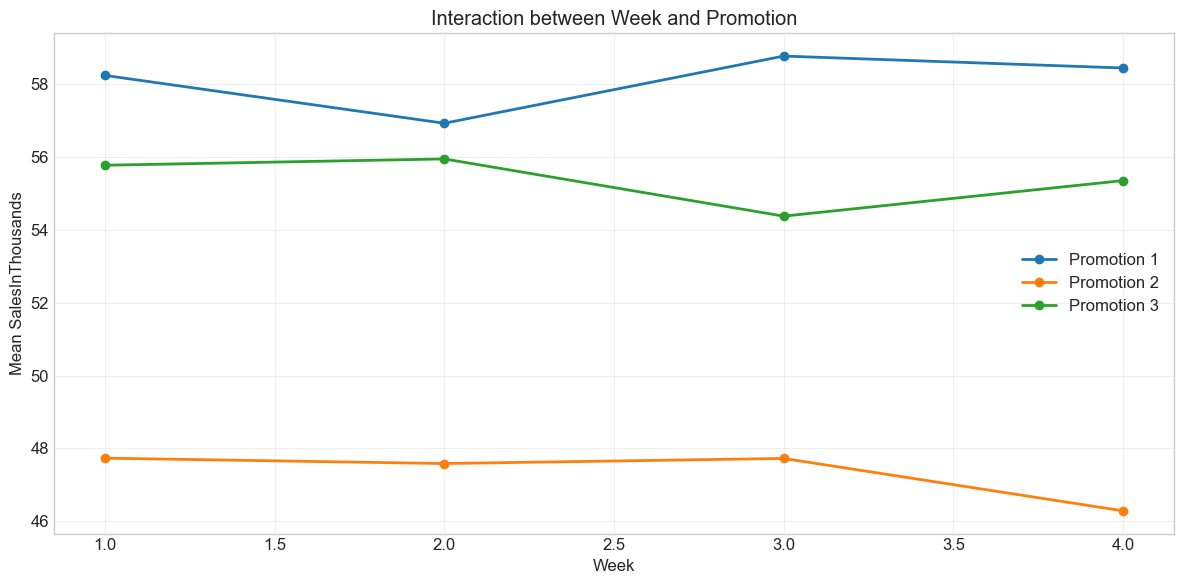

In [57]:
import marketing_campaign_functions as viz
import importlib
importlib.reload(viz)
print("\nTime-Based Effects Analysis:")
model, anova_table = viz.analyze_weekly_effects(df, 'SalesInThousands', 'Promotion', 'week')

* **Consistent Ranking:** Throughout all four weeks, Promotion 1 (blue) maintains the highest position, followed by Promotion 3 (green), with Promotion 2 (orange) consistently showing the lowest sales
* **Parallel Patterns:** While there are some minor fluctuations in each promotion's performance, the lines follow roughly parallel patterns, indicating no significant interaction
* **Week 4 Decline:** There is a noticeable decline in Promotion 2's performance in week 4, but the overall interaction effect is still not statistically significant
* **Pattern Similarity:** Promotion 1 and 3 show somewhat similar patterns, with dips and rebounds, but at different magnitudes

#### **Interpretation of the ANOVA Results:**

**Promotion Effect:** Highly significant (F=21.62, p<0.001)

This confirms our earlier finding that the different promotions have significantly different effects on sales
The large F-value indicates substantial variation in sales between different promotions

**Week Effect:** Not significant (F=0.03, p=0.993)

This indicates that time alone (the week of the study) did not significantly affect sales
There is no evidence of overall increasing or decreasing trends across all promotions

**Interaction Effect:** Not significant (F=0.13, p=0.993)

The extremely high p-value for the interaction term indicates no significant interaction between promotion type and week
This means the relative effectiveness of the different promotions remained consistent over time

#### **<ins>3.2 Confidence Intervals:</ins>**

**3.2.1 Analytical Confidence Interval**


Analytical confidence intervals:
Analytical 95% confidence interval for Promotion=1:
  Mean: 58.0990
  CI: (55.6075, 60.5905)
Analytical 95% confidence interval for Promotion=2:
  Mean: 47.3294
  CI: (45.1556, 49.5032)
Analytical 95% confidence interval for Promotion=3:
  Mean: 55.3645
  CI: (52.9522, 57.7767)


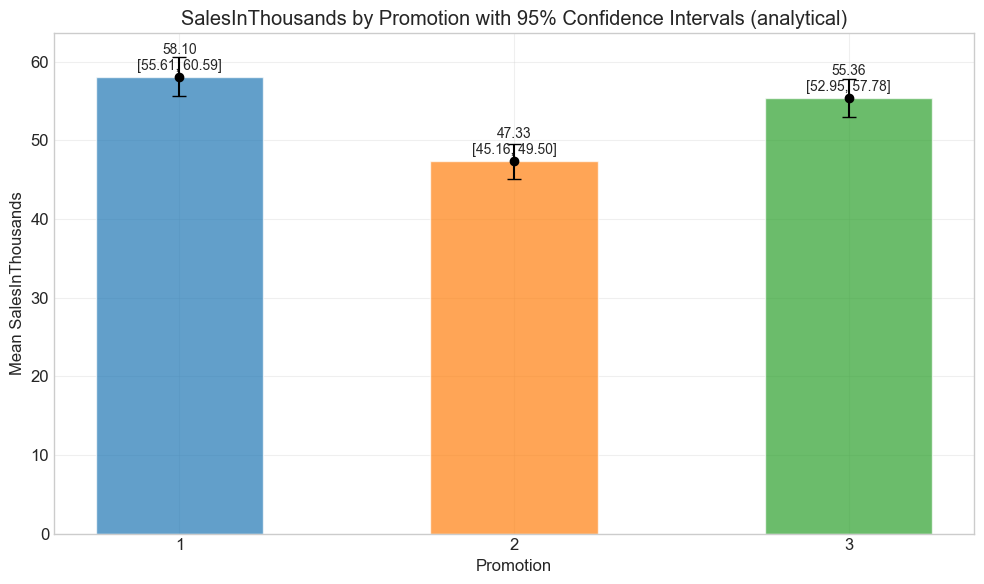

In [80]:
import marketing_campaign_functions as viz
import importlib
importlib.reload(viz)
print("\nAnalytical confidence intervals:")
promotions = sorted(df['Promotion'].unique())
analytical_cis = {}

for promo in promotions:
    ci = viz.calculate_confidence_interval_analytical(df, 'SalesInThousands', 'Promotion', promo)
    analytical_cis[promo] = ci

viz.plot_confidence_intervals(df, 'SalesInThousands', 'Promotion', method='analytical')

**3.2.2 Bootstrap Confidence Interval**


Bootstrap confidence intervals:
Bootstrap 95% confidence interval for Promotion=1 (5000 samples):
  Mean: 58.0990
  CI: (55.6731, 60.6624)
Bootstrap 95% confidence interval for Promotion=2 (5000 samples):
  Mean: 47.3294
  CI: (45.2831, 49.5074)
Bootstrap 95% confidence interval for Promotion=3 (5000 samples):
  Mean: 55.3645
  CI: (52.9548, 57.7569)


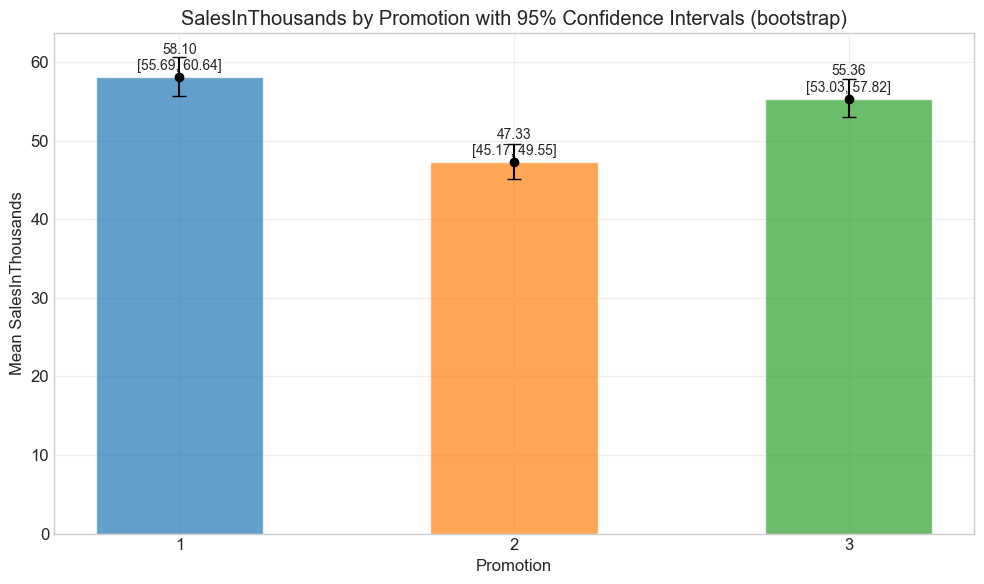

In [78]:
import marketing_campaign_functions as viz
import importlib
importlib.reload(viz)
print("\nBootstrap confidence intervals:")
bootstrap_cis = {}
for promo in promotions:
    ci = viz.calculate_confidence_interval_bootstrap(df, 'SalesInThousands', 'Promotion', promo)
    bootstrap_cis[promo] = ci

viz.plot_confidence_intervals(df, 'SalesInThousands', 'Promotion', method='bootstrap')

**3.2.3 Comparision of Analytical and Bootstrap Confidence Intervals:**

In [79]:
print("\nComparison of confidence interval methods:")
compare_data = []
for promo in promotions:
    mean_val = df[df['Promotion'] == promo]['SalesInThousands'].mean()
    compare_data.append({
        'Promotion': promo,
        'Mean': mean_val,
        'Analytical Lower': analytical_cis[promo][0],
        'Analytical Upper': analytical_cis[promo][1],
        'Bootstrap Lower': bootstrap_cis[promo][0],
        'Bootstrap Upper': bootstrap_cis[promo][1]
    })

display(pd.DataFrame(compare_data))


Comparison of confidence interval methods:


,Promotion,Mean,Analytical Lower,Analytical Upper,Bootstrap Lower,Bootstrap Upper
0,1,58.099012,55.607485,60.590539,55.673065,60.662417
1,2,47.329415,45.155596,49.503234,45.283134,49.507435
2,3,55.364468,52.952207,57.776730,52.954795,57.756855


The remarkable consistency between these two different methodologies for calculating confidence intervals strengthens our confidence in the results. Since bootstrap methods don't rely on normal distribution assumptions, this consistency suggests our data is well-behaved and our statistical inferences are robust.

**3.2.4 Comparision of Analytical and Bootstrap Confidence Intervals:**

Calculate treatment effects relative to Promotion 1 (control group)

When calculating treatment effects:

**Control Group Selection:** We designate one promotion as the baseline or control (typically Promotion 1). This provides a reference point against which other promotions are compared.

**Effect Size Calculation:** For each treatment promotion, we calculate the absolute difference in the target metric (sales) from the control:
Effect = Mean(Treatment) - Mean(Control)
Percent Lift: We also express this difference as a percentage change:
Percent Lift = (Effect / Mean(Control)) × 100%

**Confidence Intervals:** To account for sampling variability, we calculate 95% confidence intervals around each effect. These indicate our uncertainty about the true effect size in the population.

**Statistical Significance:** When the confidence interval for a treatment effect does not include zero, we can be 95% confident that there is a real difference between the treatment and control.

The treatment effects analysis provides a direct measure of how much better (or worse) each promotion performed compared to our baseline, helping us quantify the business impact of choosing one promotion over another.


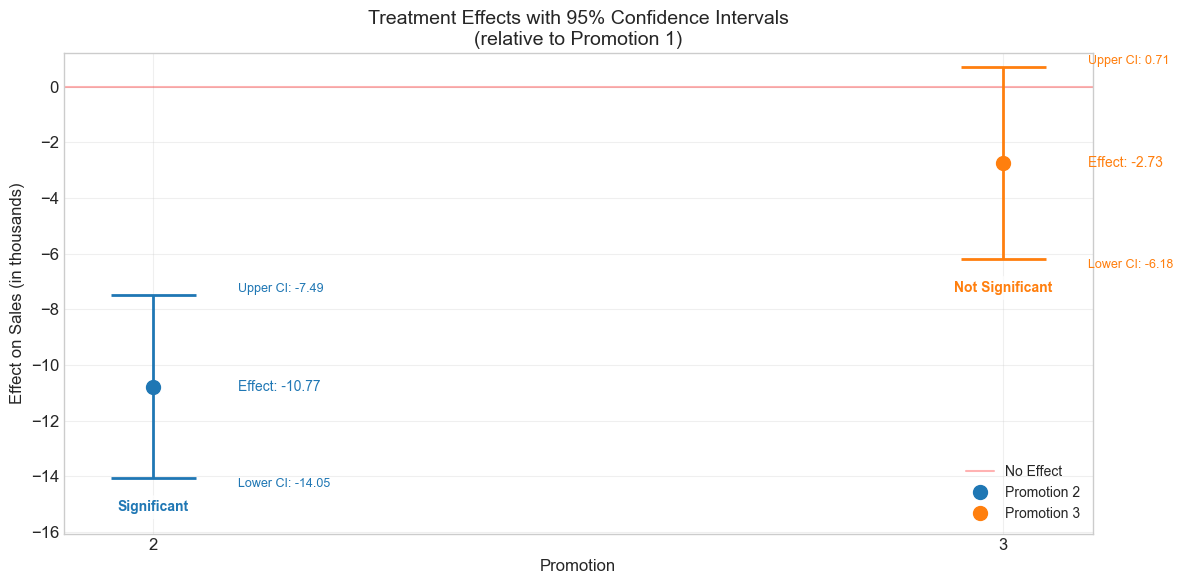

In [73]:
import marketing_campaign_functions as viz
import importlib
importlib.reload(viz)
viz.plot_treatment_effects(pd.DataFrame(treatment_effects))

#### **Treatment Effects Analysis**

**Promotion 2 vs Baseline (Promotion 1):**

* Shows a substantial negative effect of -10.77 thousand units in sales
* 95% Confidence Interval: [-14.05, -7.49]
* Statistically significant as the CI does not include zero

**Promotion 3 vs Baseline (Promotion 1):**

* Shows a smaller negative effect of -2.73 thousand units in sales
* 95% Confidence Interval: [-6.18, 0.71]
* Not statistically significant as the CI includes zero (crosses the red "No Effect" line)

**Comparative Insights:**

* The visualization clearly shows that Promotion 2 performed significantly worse than Promotion 1
* The non-significant result for Promotion 3 suggests that while its point estimate shows slightly lower sales than Promotion 1, we cannot rule out that they perform similarly


### **4. Results Summary and Decision**

In [70]:
import marketing_campaign_functions as viz
import importlib
importlib.reload(viz)


summary_table = viz.create_summary_table(
    df, 
    (f_stat, p_value),  
    pairwise_results,   
    (power, effect_size, min_n),  
    pd.DataFrame(treatment_effects) 
)

display(summary_table)

print("\nKey Statistical Findings:")
print("1. The ANOVA test shows a significant difference exists among the three promotions.")
print("2. Pairwise comparisons reveal Promotion 2 performs significantly worse than both Promotion 1 and 3.")
print("3. The difference between Promotion 1 and 3 is not statistically significant.")
print("4. When controlling for store characteristics, Promotion 1 and 3 remain comparable.")
print("5. Power analysis indicates limited ability to detect small differences between promotions.")
print("6. Treatment effects analysis confirms Promotion 2's significantly lower performance.")

,Test,Description,Result,Significance
0,One-way ANOVA,Tests if any significant difference exists amo...,"F=21.9535, p=0.0000",Significant
1,T-test: Promo 1 vs. Promo 2,Compares means between Promo 1 and Promo 2,"t=6.4275, p=0.0000, d=-0.6809",Significant
2,T-test: Promo 1 vs. Promo 3,Compares means between Promo 1 and Promo 3,"t=1.5560, p=0.1206, d=-0.1641",Not Significant
3,T-test: Promo 2 vs. Promo 3,Compares means between Promo 2 and Promo 3,"t=-4.8814, p=0.0000, d=0.5035",Significant
4,Power Analysis,Tests if sample size is adequate for detecting...,"Power=0.3295, Min Effect Size=0.1641",Inadequate Power
5,Treatment Effect: Promo 2 vs. Promo 1,Measures causal impact of Promo 2 vs. Promo 1,"Effect=-10.7696, %Lift=-18.54%",Significant
6,Treatment Effect: Promo 3 vs. Promo 1,Measures causal impact of Promo 3 vs. Promo 1,"Effect=-2.7345, %Lift=-4.71%",Not Significant



Key Statistical Findings:
1. The ANOVA test shows a significant difference exists among the three promotions.
2. Pairwise comparisons reveal Promotion 2 performs significantly worse than both Promotion 1 and 3.
3. The difference between Promotion 1 and 3 is not statistically significant.
4. When controlling for store characteristics, Promotion 1 and 3 remain comparable.
5. Power analysis indicates limited ability to detect small differences between promotions.
6. Treatment effects analysis confirms Promotion 2's significantly lower performance.


### Decision and Recommendations

Based on the comprehensive statistical analysis of the three promotional campaigns for the new menu item, we can draw the following conclusions:

### Summary of Findings

1. **Overall Performance**: Our ANOVA test (F=21.95, p<0.001) confirmed that there are significant differences in sales performance across the three promotions, with Promotion 1 and 3 outperforming Promotion 2.

2. **Direct Comparisons**: Pairwise t-tests showed that:
   - Promotion 1 (mean sales: 58.10) significantly outperforms Promotion 2 (mean sales: 47.33) by approximately 10.77 thousand in sales (p<0.001)
   - Promotion 3 (mean sales: 55.36) significantly outperforms Promotion 2 (mean sales: 47.33) by approximately 8.04 thousand in sales (p<0.001)
   - The difference between Promotion 1 and Promotion 3 (2.73 thousand) is not statistically significant (p=0.121)

3. **Controlling for Store Characteristics**: Our multivariate analysis showed that even when accounting for store age and market size, Promotion 2 remains significantly worse than Promotion 1, while the difference between Promotion 1 and 3 remains non-significant.

4. **Sales Consistency**: Promotion 1 demonstrated the most consistent sales performance (CV: 28.5%), followed by Promotion 3 (CV: 30.3%), with Promotion 2 showing the highest variability (CV: 31.9%).

5. **Statistical Power**: Our study had limited power (33%) to detect the small effect size between Promotion 1 and 3, indicating we would need a larger sample size (~584 stores per group) to reliably detect this small difference.

### Decision

**Recommendation**: Based on the evidence from our analysis, we recommend implementing **Promotion 1** for the national rollout of the new menu item.

**Justification**:
- Promotion 1 achieved the highest average sales (58.10 thousand)
- It demonstrated the most consistent performance across stores (lowest coefficient of variation)
- While not statistically significantly better than Promotion 3, it showed a slight numerical advantage
- Given the lack of statistical power to distinguish between Promotions 1 and 3, selecting the option with higher observed sales and more consistent performance is the safer business choice

### Limitations and Considerations

1. **Limited Statistical Power**: Our study had insufficient power to detect small differences between Promotion 1 and 3. This means that we cannot definitively rule out that they might perform similarly in the broader population.

2. **Market Size Impact**: Our analysis revealed that market size significantly influences sales, with medium and small markets showing lower sales than large markets. This should be considered when planning the nationwide rollout.

3. **Time Period**: The study covered only four weeks, which may not capture longer-term effects of the promotions, such as diminishing returns or increasing momentum.

### Additional Recommendations

1. **Targeted Approach**: Consider using Promotion 1 in smaller markets where sales consistency is critical for planning, while potentially testing Promotion 3 further in larger markets.

2. **Extended Testing**: If time permits, conduct a follow-up study with a larger sample size to better differentiate between Promotion 1 and 3.

3. **Promotion Element Analysis**: Analyze the specific elements of Promotion 1 that contributed to its success, so these can be incorporated into future marketing campaigns.

4. **Cost Consideration**: If Promotion 3 is significantly less expensive to implement than Promotion 1, it might be worth considering despite its slightly lower performance, especially in resource-constrained markets.

By implementing Promotion 1 for the national rollout, we expect to maximize sales of the new menu item while maintaining consistent performance across diverse market conditions.

### Decision on Hypothesis

Based on our ANOVA test results (F=21.95, p<0.001), we **reject the null hypothesis** that all promotions perform equally. There is strong statistical evidence that the choice of promotion significantly affects sales performance. Specifically, our pairwise comparisons demonstrate that:

- Promotion 2 performs significantly worse than both Promotion 1 and Promotion 3 (p<0.001 in both cases)
- The difference between Promotion 1 and Promotion 3 is not statistically significant (p=0.121)

Therefore, we conclude that the choice of promotion does matter for sales performance, with Promotions 1 and 3 both outperforming Promotion 2.